<a href="https://colab.research.google.com/github/kpe/bert-for-tf2/blob/master/examples/tpu_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this colab notebook we will create a sentiment classifier on the IMDB Movie Reviews dataset.
Our code will use the TensorFlow Keras API implementation of BERT from [kpe/bert-for-tf2](https://github.com/kpe/bert-for-tf2)
and the pre-trained BERT weights from [google-research/bert](https://github.com/google-research/bert).
We will also make use of the adapter-BERT architecture in order to fine-tune only a fraction of the weighs 
while keeping the original BERT weights frozen.

The main challenge however would be to fine-tune the classifier on a colab TPU:

Currently the combination of using a colab TPU with Keras could be quite tricky, so be prepared to do some tweaks:
 - **Google Storage Bucket** - TPUs have to load weights and training data from somewhere, and it currently looks like this has to be a google storage bucket. Therefore you'll need a write access to a bucket.
 - **GCP Authentication** - and because we have to use a Storage Bucket, we'd need to authorize our colab environment
 - **pre-trained BERT** - we'll also need to copy the pre-trained BERT weights to our storage bucket (because loading the checkpoint needs list permissions)
 - **TFRecord** - feeding data to a TPU seems to be best done using a tfrecords based dataset, so we'll convert our datasets into a tfrecord file(s) first
 - **TPU Training** - once we have the init checkpoint, we'll use `TPU Distribution Strategy` scope, to create the classification model instance.
 



# Storage Bucket Authentication

You need to setup a storage bucket in GCP for storing and loading model weights and feeding data into the TPUs.

In [0]:
import os
import tensorflow as tf

In [2]:
BUCKET = 'kpe' #@param {type:"string"}

OUTPUT_DIR = 'movie_reviews_tpu'#@param {type:"string"}

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}


OUTPUT_DIR = 'gs://{}/colab/{}'.format(BUCKET, OUTPUT_DIR)
from google.colab import auth
auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: gs://kpe/colab/movie_reviews_tpu *****


# Prerequisites

In [0]:
!pip install tqdm >> /dev/null

#!pip install -q tensorflow==2.0.0-beta1 # TPU with Keras on TF 2.0 seems to have problems, so we don't use it yet

In [0]:
import os
import math
import datetime

from functools import partial

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

In [5]:
tf.__version__

'1.14.0'

To enable the TPU - it seems to be neccessary to do this `tf.config.experimental` call in the beginning of the session:

In [6]:
USE_TPU=True
try:
  # This address identifies the TPU we'll use when configuring TensorFlow.
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.config.experimental_connect_to_host(TPU_WORKER)
except Exception as ex:
  print(ex)
  USE_TPU=False

print("        USE_TPU:", USE_TPU)
print("Eager Execution:", tf.executing_eagerly())

assert not tf.executing_eagerly(), "Eager execution on TPUs have issues currently"

        USE_TPU: True
Eager Execution: False


So lets also pip install the [bert-for-tf2](https://github.com/kpe/bert-for-tf2) python package,
that will allow us to use the Keras API when coding our classifier model.

In [0]:
!pip install bert-for-tf2 >> /dev/null

In [0]:
from bert import BertModelLayer
from bert import FullTokenizer
from bert import load_stock_weights, params_from_pretrained_ckpt

# The BERT Pre-Trained

The original pre-trained BERT weights are available in a Google Storage Bucket at `gs://bert_models/`, but without list permission which are needed by the TensorFlow APIs used for loading the weights from a checkpoint, so we have to copy the pre-trained model to our own bucket:

In [9]:
bert_ckpt_dir    = "gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12"
bert_ckpt_file   = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")
bert_model_name  = os.path.basename(os.path.dirname(bert_ckpt_file))

bert_ckpt_files = ["bert_config.json",
                   "bert_model.ckpt.data-00000-of-00001",
                   "bert_model.ckpt.index",
                   "bert_model.ckpt.meta",
                   "vocab.txt"]

gs_bert_ckpt_dir = os.path.join(OUTPUT_DIR, "bert_models", bert_model_name)
if not tf.io.gfile.exists(gs_bert_ckpt_dir):
    cmd = "gsutil -m cp {} {}".format(
        " ".join(map(partial(os.path.join, bert_ckpt_dir), bert_ckpt_files)),
        gs_bert_ckpt_dir)
    !$cmd

!gsutil ls $gs_bert_ckpt_dir

Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_config.json [Content-Type=application/json]...
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.index [Content-Type=application/octet-stream]...
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.meta [Content-Type=application/octet-stream]...
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/vocab.txt [Content-Type=text/plain]...
- [5/5 files][421.1 MiB/421.1 MiB] 100% Done                                    
Operation completed over 5 objects/421.1 MiB.                                    
gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12/bert_config.json
gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
gs://kpe/colab/movie_reviews_tpu/bert_models/un

In [10]:
bert_ckpt_dir    = gs_bert_ckpt_dir
bert_ckpt_file   = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

print("Using BERT checkpoint from:", bert_ckpt_dir)

Using BERT checkpoint from: gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12


# The IMDB Movie Review Dataset

First, let's download the dataset, hosted by Stanford. 
The code below, which downloads, extracts, and imports the IMDB Large Movie Review Dataset 
is borrowed from [this Tensorflow tutorial](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub).

In [0]:
import os
import re

# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in tqdm(os.listdir(directory), desc=os.path.basename(directory)):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df


Now we'll make a utility class `MovieReviewDatasetBuilder` for pre-processing (i.e. tokenizing) the dataset:

In [0]:
class MovieReviewDatasetBuilder:
  DATA_COLUMN = "sentence"
  LABEL_COLUMN = "polarity"

  def __init__(self, tokenizer: FullTokenizer):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    
    (self.cls_id, 
     self.sep_id,
     self.pad_id) = self.tokenizer.convert_tokens_to_ids(["[CLS]", 
                                                          "[SEP]", 
                                                          "[PAD]"])
    
    train, test = download_and_load_datasets()
    
    def sort_df(df):
      sorted_index = df[self.DATA_COLUMN].str.len().sort_values().index
      return df.reindex(sorted_index)
    
    train, test = map(sort_df, [train, test])
    
    ((self.train_ids, self.train_y),
     (self.test_ids, self.test_y)) = map(self._tokenize_data, [train, test])        
    
    print("max_seq_len", self.max_seq_len)
    
    
  def _tokenize_data(self, df):
    x, y = [], []
    with tqdm(total=df.shape[0], unit_scale=True) as pbar:
      for ndx, row in df.iterrows():
        text, label = row[self.DATA_COLUMN], row[self.LABEL_COLUMN]
        tokens = self.tokenizer.tokenize(text)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        self.max_seq_len = max(self.max_seq_len, len(token_ids))
        x.append(token_ids)
        y.append(int(label))
        pbar.update()
    return np.array(x), np.array(y)


    

# The TFRecords Conversion

We should also convert the raw dataset into TFRecord files, which are easier to feed into a TPU:

In [0]:
class MovieReviewDS:
  
  @staticmethod
  def serialize_example(token_ids, label):
    feature = {
        "token_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=token_ids)),
        "label":     tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto.SerializeToString()

  @staticmethod
  def write_tf_record(file_name, x, y):
    with tf.python_io.TFRecordWriter(file_name) as writer:
      with tqdm(total=len(x), unit_scale=True, desc=os.path.basename(file_name)) as pbar:
        for token_ids, label in zip(x, y):
          example = MovieReviewDS.serialize_example(token_ids, label)
          writer.write(example)
          pbar.update()
    
  @staticmethod
  def create_pad_example_fn(pad_len, padding=0):
    def pad_example(x, label):
      x = x[-pad_len:]
      # x = tf.concat([x, padding*tf.ones(pad_len - tf.shape(x)[-1], dtype=x.dtype)], axis=-1)
      x = tf.pad(x, [[0, pad_len - tf.shape(x)[-1]]], constant_values=padding)
      return x, label
    return pad_example
    
  @staticmethod
  def tfrecord_to_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames)
    feature_description = {
        "token_ids":  tf.io.VarLenFeature(tf.int64),
        "label":      tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    def parse_proto(proto):
      example = tf.io.parse_single_example(proto, feature_description)
      token_ids, label = example["token_ids"], example["label"]
      token_ids = tf.sparse_tensor_to_dense(token_ids)
      return token_ids, label
    
    return ds.map(parse_proto)
    

We would also store the `tfrecords` in out bucket:

In [0]:
train_tfrecord_file = os.path.join(OUTPUT_DIR, "data", "train.tfrecord")
test_tfrecord_file  = os.path.join(OUTPUT_DIR, "data", "test.tfrecord")

Converting all the data to `tfrecord` files takes few minutes, so we'll try not doing it twice: 

In [15]:
%%time 


if not all([tf.io.gfile.exists(train_tfrecord_file),
            tf.io.gfile.exists(test_tfrecord_file)]):
  print("Preparing the [train, test].tfrecord files...")
  
  tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
  data = MovieReviewDatasetBuilder(tokenizer)
  
  MovieReviewDS.write_tf_record(train_tfrecord_file, data.train_ids, data.train_y)
  MovieReviewDS.write_tf_record(test_tfrecord_file, data.test_ids, data.test_y)
else:
  data = None

!gsutil ls -la $train_tfrecord_file 
!gsutil ls -la $test_tfrecord_file

Preparing the [train, test].tfrecord files...
84131840/84125825 [==============================] - 3s 0us/step


neg: 100%|██████████| 12500/12500 [00:01<00:00, 6867.15it/s]
100%|██████████| 25.0k/25.0k [02:31<00:00, 166it/s] 
100%|██████████| 25.0k/25.0k [02:26<00:00, 171it/s] 
train.tfrecord:   5%|▍         | 1.16k/25.0k [00:00<00:02, 11.5kit/s]

max_seq_len 3155


train.tfrecord: 100%|██████████| 25.0k/25.0k [00:03<00:00, 6.93kit/s]
test.tfrecord: 100%|██████████| 25.0k/25.0k [00:03<00:00, 7.14kit/s]


  17370602  2019-08-06T10:55:25Z  gs://kpe/colab/movie_reviews_tpu/data/train.tfrecord#1565088925037707  metageneration=1
TOTAL: 1 objects, 17370602 bytes (16.57 MiB)
  17005906  2019-08-06T10:55:29Z  gs://kpe/colab/movie_reviews_tpu/data/test.tfrecord#1565088929072282  metageneration=1
TOTAL: 1 objects, 17005906 bytes (16.22 MiB)
CPU times: user 5min 26s, sys: 12.7 s, total: 5min 39s
Wall time: 5min 51s


Because BERT can handle up to 512 tokens, and because BERT computational and memory requirements scale quadratically with the input sequence length, we will have to trim the sequences to a shorter size, but let's first check the sequence length distribution, and how many examples would be affected, if we trimm all sequences to 512 tokens:

train drop count: 3701 of 25000 - 14.80%
 test drop count: 3513 of 25000 - 14.05%


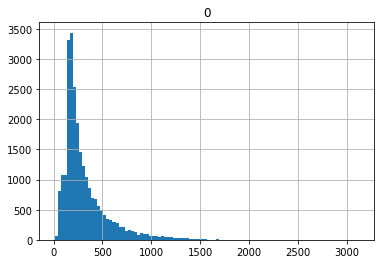

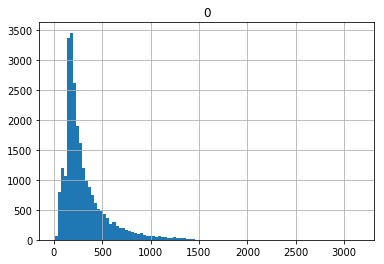

In [16]:
if data:
  train_df = pd.DataFrame(map(len, data.train_ids.tolist()))
  test_df  = pd.DataFrame(map(len, data.test_ids.tolist()))

  train_df.hist(bins=100), test_df.hist(bins=100);


  def show_drop_counts(max_seq_len = 512):
    drop_count_train, drop_count_test = map(lambda df: df[df[0] > (max_seq_len-2)].shape[0], [train_df, test_df])
    print("train drop count: {} of {} - {:5.2f}%".format(drop_count_train, len(train_df), 100*drop_count_train/len(train_df)))
    print(" test drop count: {} of {} - {:5.2f}%".format(drop_count_test, len(test_df), 100*drop_count_test/len(test_df)))
  
  show_drop_counts(512)
  

Reading the preprocessed dataset from a tfrecord file could be done like this:

In [17]:
max_seq_len = 12
train_ds = MovieReviewDS.tfrecord_to_dataset([train_tfrecord_file])
train_ds = train_ds.map(MovieReviewDS.create_pad_example_fn(pad_len=max_seq_len, 
                                                            padding=0))

test_ds = MovieReviewDS.tfrecord_to_dataset([test_tfrecord_file])
test_ds = test_ds.map(MovieReviewDS.create_pad_example_fn(pad_len=max_seq_len, 
                                                          padding=0))

train_ds_size, test_ds_size = 0, 0
if tf.executing_eagerly():
  for token_ids, label in train_ds.take(5):
    print(token_ids.shape, label.numpy(), token_ids.numpy())
  def get_ds_size(ds):
    return sum([1 for _ in ds])
  train_ds_size, test_ds_size = map(get_ds_size, [train_ds, test_ds])
else:
  def get_ds_size(ds):
    count = 0
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      it = ds.batch(128).make_one_shot_iterator()
      tok_ids,labels = it.get_next()
  
      try:
        while True:
          res = sess.run(labels)
          count += res.shape[0]
      except Exception as ex:
        pass
    return count
  train_ds_size, test_ds_size = map(get_ds_size, [train_ds, test_ds])
  
print("train size:", train_ds_size)
print(" test size:", test_ds_size)

  

W0806 10:55:36.281256 140206113781632 deprecation.py:323] From <ipython-input-17-a645a183e8d5>:22: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


train size: 25000
 test size: 25000


# The Model (finally)


Lets define some helpers for freezing some selected BERT layers, which is need for [adapter-BERT](https://arxiv.org/abs/1902.00751).

In [0]:

def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False


def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler



Now let's create a classification model using [adapter-BERT](https//arxiv.org/abs/1902.00751), which is a clever way 
of reducing the trainable parameter count, by freezing the original BERT weights, 
and adapting the internal activations with two FFN bottlenecks (i.e. `adapter_size` bellow) in every BERT layer.

In [0]:
def create_model(max_seq_len, 
                 adapter_size=64,
                 batch_size=None,
                 init_ckpt_file=None,
                 init_bert_ckpt_file=bert_ckpt_file,
                ):
  """Creates a classification model.
  :param adapter_size: adapter bottleneck size - arXiv:1902.00751
  """

  bert_params = params_from_pretrained_ckpt(os.path.dirname(init_bert_ckpt_file))
  
  # create the bert layer
  bert_params.adapter_size = adapter_size
  l_bert = BertModelLayer.from_params(bert_params, name="bert")

  model = keras.models.Sequential([
      keras.layers.InputLayer(input_shape=(max_seq_len,), batch_size=batch_size,
                              dtype="int32", name="input_ids"),
      l_bert,
      keras.layers.Lambda(lambda seq: seq[:, 0, :]),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(units=bert_params.hidden_size, activation="relu"),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(units=2, activation="softmax")
  ])
  
  # freeze the weights if adapter-BERT is used
  #    we need to freeze the layers
  #    before we do build/compile 
  #    otherwise keras counts the params twice in its Model Summary Total
  if adapter_size is not None:
    freeze_bert_layers(l_bert)
  
  model.build(input_shape=(batch_size, max_seq_len))
  
  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

  # load the pre-trained model weights (once the input_shape is known)
  if init_ckpt_file:
    print("Loading model weights from:", init_ckpt_file)
    model.load_weights(init_ckpt_file)
  elif init_bert_ckpt_file:
    print("Loading pre-trained BERT layer from:", init_bert_ckpt_file)
    load_stock_weights(l_bert, init_bert_ckpt_file)

  
  model.summary()
        
  return model


Bigger `max_seq_len` in a transformer model slows things quite a bit, 
but will select the maximum for BERT which is 512:

In [0]:
adapter_size = 64
max_seq_len  = 512
batch_size   = 128

So we are now finally ready to create our model. To make it run on a TPU, we need to wrap the 
creation into a `TPUStrategy` scope:

In [21]:
assert not tf.executing_eagerly()

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

with tpu_strategy.scope():
  model = create_model(max_seq_len,
                       adapter_size, 
                       batch_size=batch_size,
                       init_bert_ckpt_file=bert_ckpt_file)

model.summary()

W0806 10:55:49.429897 140206113781632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0806 10:55:49.569336 140206113781632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0806 10:56:10.608681 140206113781632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/bert/loader.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is depr

Loading pre-trained BERT layer from: gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[gs://kpe/colab/movie_reviews_tpu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[gs://kpe/colab/movie_rev

In [22]:

ds = MovieReviewDS.tfrecord_to_dataset([train_tfrecord_file])
ds = ds.map(MovieReviewDS.create_pad_example_fn(pad_len=max_seq_len, 
                                                padding=0))
def set_example_shape(token_ids, label):
  return tf.reshape(token_ids, (max_seq_len,)), tf.reshape(label, ())


ds = ds.map(set_example_shape)
ds = ds.cache()
ds = ds.shuffle(buffer_size=2500, seed=4711, reshuffle_each_iteration=True)

#train_size  = int((25000*0.9//128)*128)
#train_ds = ds.take(train_size)
#valid_ds = ds.batch
#ds = train_ds.cache()
#ds = ds.shuffle(buffer_size=batch_size*32, reshuffle_each_iteration=True)

ds = ds.repeat()
ds = ds.batch(batch_size, drop_remainder=True)
train_ds = ds

W0806 10:57:13.497962 140206113781632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Once the model is trained, we'll store it in our bucket:

In [0]:
trained_ckpt_file = os.path.join(OUTPUT_DIR, 'checkpoints','trained','movie_reviews.ckpt')

and now lets proceed with the actual training on a TPU:

In [24]:
#%%time

if tf.io.gfile.exists(trained_ckpt_file):
  model.load_weights(trained_ckpt_file)
else:
  log_dir = os.path.join(OUTPUT_DIR, "log", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

  total_epoch_count = 30

  model.fit(train_ds,
            shuffle=True,
            epochs=total_epoch_count,
            steps_per_epoch=25000//batch_size,
            callbacks=[create_learning_rate_scheduler(max_learn_rate=5e-5,
                                                      end_learn_rate=5e-7,
                                                      warmup_epoch_count=10,
                                                      total_epoch_count=total_epoch_count),
                       keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                       tensorboard_callback])
  model.save_weights(trained_ckpt_file, overwrite=True)

W0806 10:58:27.599105 140206113781632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_distributed.py:411: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.



Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/30
  2/195 [..............................] - ETA: 56:55 - loss: 5.6345 - acc: 0.5312  

W0806 10:59:02.997966 140206113781632 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (1.092324). Check your callbacks.


194/195 [============================>.] - ETA: 0s - loss: 5.6958 - acc: 0.5033

W0806 11:00:30.795150 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 124s 638ms/step - loss: 5.6965 - acc: 0.5031

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 2/30
194/195 [============================>.] - ETA: 0s - loss: 5.3282 - acc: 0.5924

W0806 11:02:00.764044 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 5.3248 - acc: 0.5931

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5000000000000002e-05.
Epoch 3/30
194/195 [============================>.] - ETA: 0s - loss: 3.8127 - acc: 0.8326

W0806 11:03:29.972693 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.8112 - acc: 0.8328

Epoch 00004: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 4/30
194/195 [============================>.] - ETA: 0s - loss: 3.5047 - acc: 0.8692

W0806 11:04:59.644582 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.5068 - acc: 0.8689

Epoch 00005: LearningRateScheduler reducing learning rate to 2.5e-05.
Epoch 5/30
194/195 [============================>.] - ETA: 0s - loss: 3.4054 - acc: 0.8827

W0806 11:06:28.900254 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.4060 - acc: 0.8826

Epoch 00006: LearningRateScheduler reducing learning rate to 3.0000000000000004e-05.
Epoch 6/30
194/195 [============================>.] - ETA: 0s - loss: 3.3660 - acc: 0.8882

W0806 11:07:58.940879 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.3656 - acc: 0.8883

Epoch 00007: LearningRateScheduler reducing learning rate to 3.5000000000000004e-05.
Epoch 7/30
194/195 [============================>.] - ETA: 0s - loss: 3.3091 - acc: 0.8958

W0806 11:09:28.114408 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 460ms/step - loss: 3.3111 - acc: 0.8956

Epoch 00008: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 8/30
194/195 [============================>.] - ETA: 0s - loss: 3.2701 - acc: 0.9003

W0806 11:10:57.898444 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.2708 - acc: 0.9002

Epoch 00009: LearningRateScheduler reducing learning rate to 4.5e-05.
Epoch 9/30
194/195 [============================>.] - ETA: 0s - loss: 3.2744 - acc: 0.9003

W0806 11:12:27.236196 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 462ms/step - loss: 3.2756 - acc: 0.9002

Epoch 00010: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 10/30
194/195 [============================>.] - ETA: 0s - loss: 3.2075 - acc: 0.9091

W0806 11:13:57.290508 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 3.2089 - acc: 0.9089

Epoch 00011: LearningRateScheduler reducing learning rate to 4.015428610695757e-05.
Epoch 11/30
194/195 [============================>.] - ETA: 0s - loss: 3.1997 - acc: 0.9100

W0806 11:15:26.385341 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.2010 - acc: 0.9099

Epoch 00012: LearningRateScheduler reducing learning rate to 3.2247333855188115e-05.
Epoch 12/30
194/195 [============================>.] - ETA: 0s - loss: 3.1605 - acc: 0.9144

W0806 11:16:56.096100 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.1616 - acc: 0.9143

Epoch 00013: LearningRateScheduler reducing learning rate to 2.5897373396156056e-05.
Epoch 13/30
194/195 [============================>.] - ETA: 0s - loss: 3.1550 - acc: 0.9159

W0806 11:18:25.468137 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.1560 - acc: 0.9158

Epoch 00014: LearningRateScheduler reducing learning rate to 2.0797810815359234e-05.
Epoch 14/30
194/195 [============================>.] - ETA: 0s - loss: 3.1238 - acc: 0.9203

W0806 11:19:55.265007 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 3.1265 - acc: 0.9200

Epoch 00015: LearningRateScheduler reducing learning rate to 1.670242491756622e-05.
Epoch 15/30
194/195 [============================>.] - ETA: 0s - loss: 3.1321 - acc: 0.9190

W0806 11:21:24.600560 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.1340 - acc: 0.9188

Epoch 00016: LearningRateScheduler reducing learning rate to 1.341347897639863e-05.
Epoch 16/30
194/195 [============================>.] - ETA: 0s - loss: 3.1166 - acc: 0.9205

W0806 11:22:54.508530 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 3.1172 - acc: 0.9204

Epoch 00017: LearningRateScheduler reducing learning rate to 1.0772173450159417e-05.
Epoch 17/30
194/195 [============================>.] - ETA: 0s - loss: 3.1134 - acc: 0.9211

W0806 11:24:23.681378 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 460ms/step - loss: 3.1137 - acc: 0.9210

Epoch 00018: LearningRateScheduler reducing learning rate to 8.65097869422947e-06.
Epoch 18/30
194/195 [============================>.] - ETA: 0s - loss: 3.0902 - acc: 0.9247

W0806 11:25:53.453275 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 3.0903 - acc: 0.9247

Epoch 00019: LearningRateScheduler reducing learning rate to 6.947477471865686e-06.
Epoch 19/30
194/195 [============================>.] - ETA: 0s - loss: 3.0948 - acc: 0.9243

W0806 11:27:22.794784 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.0954 - acc: 0.9242

Epoch 00020: LearningRateScheduler reducing learning rate to 5.5794199625387414e-06.
Epoch 20/30
194/195 [============================>.] - ETA: 0s - loss: 3.0900 - acc: 0.9251

W0806 11:28:52.768064 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.0904 - acc: 0.9250

Epoch 00021: LearningRateScheduler reducing learning rate to 4.480752509733022e-06.
Epoch 21/30
194/195 [============================>.] - ETA: 0s - loss: 3.0864 - acc: 0.9251

W0806 11:30:22.033513 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.0872 - acc: 0.9251

Epoch 00022: LearningRateScheduler reducing learning rate to 3.59842836500576e-06.
Epoch 22/30
194/195 [============================>.] - ETA: 0s - loss: 3.0880 - acc: 0.9251

W0806 11:31:51.857927 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 3.0901 - acc: 0.9249

Epoch 00023: LearningRateScheduler reducing learning rate to 2.8898464420766556e-06.
Epoch 23/30
194/195 [============================>.] - ETA: 0s - loss: 3.0886 - acc: 0.9246

W0806 11:33:20.991935 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.0900 - acc: 0.9244

Epoch 00024: LearningRateScheduler reducing learning rate to 2.320794416806389e-06.
Epoch 24/30
194/195 [============================>.] - ETA: 0s - loss: 3.0894 - acc: 0.9242

W0806 11:34:50.818702 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.0897 - acc: 0.9242

Epoch 00025: LearningRateScheduler reducing learning rate to 1.8637968601574692e-06.
Epoch 25/30
194/195 [============================>.] - ETA: 0s - loss: 3.0820 - acc: 0.9263

W0806 11:36:19.894803 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 460ms/step - loss: 3.0821 - acc: 0.9262

Epoch 00026: LearningRateScheduler reducing learning rate to 1.4967886473602442e-06.
Epoch 26/30
194/195 [============================>.] - ETA: 0s - loss: 3.0805 - acc: 0.9263

W0806 11:37:49.775589 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 458ms/step - loss: 3.0811 - acc: 0.9262

Epoch 00027: LearningRateScheduler reducing learning rate to 1.202049591754986e-06.
Epoch 27/30
194/195 [============================>.] - ETA: 0s - loss: 3.0807 - acc: 0.9259

W0806 11:39:18.902029 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.0807 - acc: 0.9258

Epoch 00028: LearningRateScheduler reducing learning rate to 9.653488644416245e-07.
Epoch 28/30
194/195 [============================>.] - ETA: 0s - loss: 3.0867 - acc: 0.9246

W0806 11:40:48.958532 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.0874 - acc: 0.9246

Epoch 00029: LearningRateScheduler reducing learning rate to 7.752578899163118e-07.
Epoch 29/30
194/195 [============================>.] - ETA: 0s - loss: 3.0762 - acc: 0.9265

W0806 11:42:18.208779 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 90s 461ms/step - loss: 3.0769 - acc: 0.9264

Epoch 00030: LearningRateScheduler reducing learning rate to 6.225985423675161e-07.
Epoch 30/30
194/195 [============================>.] - ETA: 0s - loss: 3.0866 - acc: 0.9256

W0806 11:43:48.085472 140206113781632 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


195/195 [==============================] - 89s 457ms/step - loss: 3.0861 - acc: 0.9257


# Evaluation

To evaluate, we'd prepare a dataset:

In [0]:

def to_model_ds(tfrecord_file, batch_size=batch_size, drop_remainder=True):
  ds = MovieReviewDS.tfrecord_to_dataset([tfrecord_file])
  ds = ds.map(MovieReviewDS.create_pad_example_fn(pad_len=max_seq_len, 
                                                  padding=0))
  def set_example_shape(token_ids, label):
    return tf.reshape(token_ids, (max_seq_len,)), tf.reshape(label, ())

  ds = ds.map(set_example_shape)
  ds = ds.batch(batch_size, drop_remainder=drop_remainder)
  return ds

and call evaluate:

In [26]:

_, train_acc = model.evaluate(to_model_ds(train_tfrecord_file), steps=25000//batch_size)
_, test_acc = model.evaluate(to_model_ds(test_tfrecord_file), steps=25000//batch_size)

print("train acc", train_acc)
print(" test acc", test_acc)

195/195 [==============================] - 80s 411ms/step
train acc 0.9323317
 test acc 0.9233174


We could also create a new model, load the trained checkpoint and evaluate. 
Beware however that this would take ages on a CPU, so you might prefer running the lines below in a new GPU session:

In [0]:
trained_ckpt_file = os.path.join(OUTPUT_DIR, 'checkpoints','trained','movie_reviews.ckpt')

model = create_model(max_seq_len, 
                     adapter_size=adapter_size,
                     init_ckpt_file=trained_ckpt_file)

_, train_acc = model.evaluate(to_model_ds(train_tfrecord_file, drop_remainder=False))
_, test_acc = model.evaluate(to_model_ds(test_tfrecord_file, drop_remainder=False))

print("train acc", train_acc)
print(" test acc", test_acc)

Loading model weights from: gs://kpe/colab/movie_reviews_tpu/checkpoints/trained/movie_reviews.ckpt
